In [1]:
from keras.optimizers import Adam,sgd
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import scale
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
from pathlib import Path
import numpy as np
import math
import glob
import pickle
import random
import os


#train_files,test_files = get_data_files()
#print(train_files)
def train_val_split(train_AP_features,train_labels,fp_ratio):
    #generate len(train_AP_features) of floats in between 0 and 1
    train_val_split = np.random.rand(len(train_AP_features))
    #convert train_val_split to an array of booleans: if elem < 0.7 = true, else: false
    train_val_split = train_val_split < fp_ratio #should contain ~70% percent true
    # We will then split our given training set into training + validation 
    train_X = train_AP_features[train_val_split]
    train_y = train_labels[train_val_split]
    val_X = train_AP_features[~train_val_split]
    val_y = train_labels[~train_val_split]
    return train_X,train_y, val_X, val_y

def normalization(data):
    minVals = data.min(0)
    maxVals = data.max(0)
    ranges = maxVals - minVals
    normData = (data - minVals)/ranges
    return normData,ranges,minVals

def load_data(file_name):
    df = pd.read_csv(file_name,header = 0)
    #print(df.head(2))
    AP_strengths = df.loc[:,'WAP001':'WAP520']
    AP_strengths = AP_strengths.replace([100], [-100])
    print(AP_strengths.head(2))
    df_xy = df.loc[:,'LONGITUDE':'LATITUDE']
    labels = np.asarray(df_xy)
    AP_features = (np.asarray(AP_strengths))
    
    building_ids_str = df["BUILDINGID"].map(str) #convert all the building ids to strings
    building_floors_str = df["FLOOR"].map(str) #convert all the building floors to strings
    return AP_features, building_ids_str, building_floors_str, labels


def mean_squared_error(y_true, y_pred):
    return math.sqrt((y_true[0]-y_pred[0])**2+(y_true[1]-y_pred[1])**2)


def rms(list):
    sum = 0
    for term in list:
        sum+= term*term
    rms = math.sqrt(sum / len(list))
    return rms
def save_to_log(file_name,preds_pos):
    write_file = open(file_name,'w')
    for pos in preds_pos:
        line = str(pos[0])+','+str(pos[1])+'\n'
        write_file.write(line)
    return 
def load_log(file_name):
    read_file = open(file_name,'r')
    lines = read_file.readlines()
    pred_pos = []
    for line in lines:
        pos = line.split(',')
        x = float(pos[0])
        y = float(pos[1])
        pred_pos.append([x,y])
    return pred_pos

def cdf(error):
    count = len(error)
    cdf_y = [i/count for i in range(count)]
    error_sorted = sorted(error)
    plt.xlim(0,50)
    plt.ylim(0,1)
    plt.plot(error_sorted, cdf_y)
    plt.show()
    return cdf_y,error_sorted

def error_analysis(pred_y,true_y):
    error =np.sqrt((pred_y[:,0]-true_y[:,0])**2+(pred_y[:,1]-true_y[:,1])**2)
    rms_error = rms(error)
    print('rms_error:', rms_error)
    mean_error = sum(error)/len(error)
    print('mean_error:', mean_error)
    print("generating cdf:")
    cdf_y,error_sorted = cdf(error)
    return 

Using TensorFlow backend.
/home/zhangzheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zhangzheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zhangzheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zhangzheng/.local/lib/python3.7/site-packages/t

In [2]:
def cnn(input_data):
    print("using CNN")
    wapid_dim = input_data[0].shape[1]
    wapid_input_layer = L.Input(shape=(wapid_dim,))
    wap_emb = L.Embedding(520,40)(wapid_input_layer)
    wap_emb = L.BatchNormalization()(wap_emb)
    wap_emb = L.Flatten()(wap_emb)
    
    rssi_f_dim = input_data[1].shape[1]
    rssi_f_input_layer = L.Input(shape=(rssi_f_dim,))
    rssi_f = L.BatchNormalization()(rssi_f_input_layer)
    rssi_f_feature = L.Dense(16*40, activation='relu')(rssi_f)
    
    
    input_site_layer = L.Input(shape=(1,))
    print("input_site_layer", input_site_layer.shape)
    site_emb = L.Embedding(13, 1)(input_site_layer)
    print("site_emb1", site_emb.shape)
    site_emb = L.Flatten()(site_emb)
    print("site_emb2", site_emb.shape)
    site_emb = L.BatchNormalization()(site_emb)
    print("site_emb3", site_emb.shape)
    x = L.Concatenate(axis=1)([wap_emb, rssi_f_feature])
    x = L.BatchNormalization()(x)
    x = L.Dropout(0.2)(x)
    x = L.Dense(256, activation='relu')(x)
    x = L.Dropout(0.1)(x)
    x = L.Dense(128, activation='relu')(x)
    print("before",x.shape)
    x = L.Reshape((128, 1))(x)
    print("before2",x.shape)
    x = L.BatchNormalization()(x)   # input 128
    x = L.Conv1D(32, 3, strides=1, dilation_rate=1, activation='relu')(x)   # input 128, output 126
    print("CNN1",x.shape)
    y = x
    x = L.BatchNormalization()(x)
    x = L.Conv1D(64, 5, strides=2, dilation_rate=1, activation='relu')(x)   # input 126, output (126-5+0)/2+1 = 61
    x = L.BatchNormalization()(x)
    x = L.Conv1D(128, 7, strides=2, dilation_rate=1, activation='relu')(x)  # input 61, output (61-7+0)/2+1 = 28
    x = L.BatchNormalization()(x)
    x = L.Conv1D(64, 9, strides=1, dilation_rate=1, activation='relu')(x)  # input 23, output (28-9+0)/1+1 = 20
    x = L.BatchNormalization()(x)
    x = L.Conv1D(32, 5, strides=1, dilation_rate=1, activation='relu')(x)   # input 20, output (20-5+0)/1+1 = 16
    print("CNN_5 ", x.shape)
    x = L.Concatenate(axis=1)([x, y])
    x = L.BatchNormalization()(x)
    print("CNN_res ", x.shape)
    x = L.Conv1D(1, 1, strides=1, dilation_rate=1, activation='relu')(x)    # gloabl average pooling
    x = L.BatchNormalization()(x)  
    print("after cnn", x.shape)
    x = L.Flatten()(x)
    print("after flatten", x.shape)
    x = L.Dense(64, activation='relu')(x)
    x = L.Concatenate(axis=1)([x,site_emb])
    x = L.Dense(32, activation='relu')(x)
    output_layer_1 = L.Dense(2, name='xy')(x)
    model = M.Model([wapid_input_layer, rssi_f_input_layer, input_site_layer], [output_layer_1])
    model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
    return model

def cnn_lstm(input_data):
    wapid_dim = input_data[0].shape[1]
    wapid_input_layer = L.Input(shape=(wapid_dim,))
    wap_emb = L.Embedding(520,40)(wapid_input_layer)
    wap_emb = L.BatchNormalization()(wap_emb)
    wap_emb = L.Flatten()(wap_emb)
    
    rssi_f_dim = input_data[1].shape[1]
    rssi_f_input_layer = L.Input(shape=(rssi_f_dim,))
    rssi_f = L.BatchNormalization()(rssi_f_input_layer)
    rssi_f_feature = L.Dense(16*40, activation='relu')(rssi_f)
    
    
    input_site_layer = L.Input(shape=(1,))
    site_emb = L.Embedding(13, 1)(input_site_layer)
    site_emb = L.Flatten()(site_emb)
    site_emb = L.BatchNormalization()(site_emb)
    x = L.Concatenate(axis=1)([wap_emb, rssi_f_feature])
    x = L.BatchNormalization()(x)
    x = L.Dropout(0.2)(x)
    x = L.Dense(256, activation='relu')(x)
    x = L.Dropout(0.1)(x)
    x = L.Dense(128, activation='relu')(x)
    #x = L.Dropout(0.2)(x)
    x = L.Reshape((128, 1))(x)
    # x = L.Reshape((-1, 1))(x)
    x = L.BatchNormalization()(x)
    
    x = L.Conv1D(32, 3, strides=1, dilation_rate=1, activation='relu')(x)   # input 128, output 126
    y = x
    print("CNN1",x.shape)
    x = L.BatchNormalization()(x)
    x = L.Conv1D(64, 5, strides=2, dilation_rate=1, activation='relu')(x)   # input 126, output (126-5+0)/2+1 = 61
    x = L.BatchNormalization()(x)
    x = L.Conv1D(128, 7, strides=2, dilation_rate=1, activation='relu')(x)  # input 61, output (61-7+0)/2+1 = 28
    x = L.BatchNormalization()(x)
    x = L.Conv1D(64, 9, strides=1, dilation_rate=1, activation='relu')(x)  # input 23, output (28-9+0)/1+1 = 20
    x = L.BatchNormalization()(x)
    x = L.Conv1D(32, 5, strides=1, dilation_rate=1, activation='relu')(x)   # input 20, output (20-5+0)/1+1 = 16
    x = L.BatchNormalization()(x)
    # x = L.Concatenate(axis=1)([x, y])
    # x = L.Dense(64, activation='relu')(x)
    x = L.Conv1D(1, 1, strides=1, dilation_rate=1, activation='relu')(x)    # gloabl average pooling
    print("after conv1D", x.shape)
    x = L.BatchNormalization()(x) 
    x = L.LSTM(128, dropout=0, return_sequences=True, activation='sigmoid')(x)
    x = L.LSTM(16, dropout=0, return_sequences=False, activation='sigmoid')(x)
    print("after LSTM ", x.shape)
    x = L.Concatenate(axis=1)([x,site_emb]) 
    x = L.Dense(64, activation='relu')(x)
    x = L.Dense(16, activation='relu')(x)
    #x = L.Dropout(0.1)(x)
    output_layer_1 = L.Dense(2, name='xy', activation='sigmoid')(x)
    model = M.Model([wapid_input_layer, rssi_f_input_layer, input_site_layer], [output_layer_1])
    model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
    return model
def mlp(input_data):
    wapid_dim = input_data[0].shape[1]
    wapid_input_layer = L.Input(shape=(wapid_dim,))
    wap_emb = L.Embedding(520,40)(wapid_input_layer)
    wap_emb = L.BatchNormalization()(wap_emb)
    wap_emb = L.Flatten()(wap_emb)
    
    rssi_f_dim = input_data[1].shape[1]
    rssi_f_input_layer = L.Input(shape=(rssi_f_dim,))
    rssi_f = L.BatchNormalization()(rssi_f_input_layer)
    rssi_f_feature = L.Dense(16*40, activation='relu')(rssi_f)
    
    
    input_site_layer = L.Input(shape=(1,))
    site_emb = L.Embedding(13, 1)(input_site_layer)
    site_emb = L.Flatten()(site_emb)
    site_emb = L.BatchNormalization()(site_emb)
    x = L.Concatenate(axis=1)([wap_emb, rssi_f_feature])
    x = L.BatchNormalization()(x)
    x = L.Dropout(0.1)(x)
    x = L.Dense(256, activation='relu')(x)
    x = L.Dropout(0.2)(x)
    #x = L.Reshape((-1, 1))(x)
    x = L.BatchNormalization()(x)
    x = L.Dense(128,activation='relu')(x)
    x = L.Dropout(0.1)(x)
    x = L.Dense(64, activation='relu')(x)
    x = L.Concatenate(axis=1)([x,site_emb])
    x = L.Dense(16, activation='relu')(x)
    #x = L.Dropout(0.1)(x)
    output_layer_1 = L.Dense(2, name='xy')(x)
    model = M.Model([wapid_input_layer, rssi_f_input_layer, input_site_layer], [output_layer_1])
    model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
    model.summary()
    return model
def lstm(input_data):
    wapid_dim = input_data[0].shape[1]
    wapid_input_layer = L.Input(shape=(wapid_dim,))
    wap_emb = L.Embedding(520,40)(wapid_input_layer)
    wap_emb = L.BatchNormalization()(wap_emb)
    wap_emb = L.Flatten()(wap_emb)
    
    rssi_f_dim = input_data[1].shape[1]
    rssi_f_input_layer = L.Input(shape=(rssi_f_dim,))
    rssi_f = L.BatchNormalization()(rssi_f_input_layer)
    rssi_f_feature = L.Dense(16*40, activation='relu')(rssi_f)
    
    
    input_site_layer = L.Input(shape=(1,))
    site_emb = L.Embedding(13, 1)(input_site_layer)
    site_emb = L.Flatten()(site_emb)
    site_emb = L.BatchNormalization()(site_emb)
    x = L.Concatenate(axis=1)([wap_emb, rssi_f_feature])
    x = L.BatchNormalization()(x)
    #x = L.Dropout(0.2)(x)
    #x = L.Dense(256, activation='relu')(x)
    x = L.Dropout(0.1)(x)
    x = L.Dense(128, activation='relu')(x)
    #x = L.Dropout(0.2)(x)
    x = L.Reshape((-1, 1))(x)
    print(x.shape)
    x = L.BatchNormalization()(x)
    x = L.LSTM(128, dropout=0.1, recurrent_dropout=0, return_sequences=True, activation='sigmoid')(x)
    x = L.LSTM(64, dropout=0.1, return_sequences=False, activation='sigmoid')(x)
    #x = L.Dense(128,activation='relu')(x)
    #x = L.Dropout(0.2)(x)
    #x = L.Reshape((-1, 1))(x)
    x = L.Dense(64, activation='relu')(x)
    #x = L.LSTM(16, dropout=0, return_sequences=False, activation='relu')(x)
    x = L.Concatenate(axis=1)([x,site_emb])
    x = L.Dense(16, activation='relu')(x)
    #x = L.Dropout(0.1)(x)
    output_layer_1 = L.Dense(2, name='xy')(x)
    model = M.Model([wapid_input_layer, rssi_f_input_layer, input_site_layer], [output_layer_1])
    model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
    return model

In [ ]:
def altered_rssi_analysis():
    from sklearn import neighbors
    path_train = "trainingData.csv"
    path_validation = "validationData.csv"
    train_df = pd.read_csv(path_train,header = 0)
    train_AP_strengths =train_df.loc[:,'WAP001':'WAP520']
    building_ids_str = train_df["BUILDINGID"].map(str) #convert all the building ids to strings
    building_floors_str = train_df["FLOOR"].map(str) #convert all the building floors to strings
    floor_enc = LabelEncoder()
    floor_enc.fit(building_floors_str)
    floor_id = floor_enc.transform(building_floors_str)
    floor_id = floor_id.reshape(-1,1)
    building_enc = LabelEncoder()
    building_enc.fit(building_ids_str)
    building_id = building_enc.transform(building_ids_str)
    train_building_id = building_id.reshape(-1,1)
    train_AP_features = np.array(train_AP_strengths.replace([100],[-150]))
    train_id = np.argsort(train_AP_features)[:,504:520]
    train_rssi = np.sort(train_AP_features)[:,504:520]
    print(train_rssi[10])
    print(train_id[10])
    print(train_AP_features[train_id[10]])
    train_df_LL = train_df.loc[:,'LONGITUDE':'LATITUDE']
    train_labels = np.asarray(train_df_LL)
    train_y,ranges,bias =  normalization(train_labels)
    print(bias,ranges)
    test_df = pd.read_csv(path_validation,header = 0)
    print(test_df.head(2))
    test_AP_strengths =test_df.loc[:,'WAP001':'WAP520']
    #test_AP_features = np.array(test_AP_strengths.replace([100], [-100]))
    test_building_ids_str = test_df["BUILDINGID"].map(str) #convert all the building ids to strings
    test_building_floors_str = test_df["FLOOR"].map(str) #convert all the building floors to strings
    #print(id_label)
    test_floor_enc = LabelEncoder()
    test_floor_enc.fit(building_floors_str)
    test_floor_id = test_floor_enc.transform(test_building_floors_str)
    test_floor_id = test_floor_id.reshape(-1,1)
    print("test floor id",(test_floor_id.shape))
    test_building_enc = LabelEncoder()
    test_building_enc.fit(test_building_ids_str)
    test_building_id = test_building_enc.transform(test_building_ids_str)
    test_building_id = test_building_id.reshape(-1,1)
    print("test building id:",(test_building_id.shape))
    test_AP_features = np.array(test_AP_strengths.replace([100],[-150]))
    test_id = np.argsort(test_AP_features)[:,504:520]
    test_rssi = np.sort(test_AP_features)[:,504:520]
    test_rssi_floor = np.hstack((test_rssi,test_floor_id))
    print(test_rssi_floor[0], test_rssi_floor.shape)
    test_df_LL = test_df.loc[:,'LONGITUDE':'LATITUDE']
    test_y = np.asarray(test_df_LL)
    for i in range(1,6):
        ratio = i * 2
        train_rssi =  train_rssi + np.random.normal(0, 2*i, None)
        input_data = [train_id, train_rssi, train_building_id]

        model = cnn_lstm(input_data)
        #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'cnn_lstm_layer_altered_' + str(2*i)+ '_db.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()

        
        model = lstm(input_data)
        #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'lstm_layer_altered_' + str(2*i)+ '_db.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()

        
        # CNN
        model = cnn(input_data)
        #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'cnn_layer_altered_' + str(i*2)+ '_db.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()


        # MLP

        model = mlp(input_data)
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'mlp_layer_altered_' + str(ratio)+ '_db.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()
        #LSTM


#altered_rssi_analysis()

In [ ]:
def masked_rssi_analysis():
    from sklearn import neighbors
    path_train = "trainingData.csv"
    path_validation = "validationData.csv"
    train_df = pd.read_csv(path_train,header = 0)
    train_AP_strengths =train_df.loc[:,'WAP001':'WAP520']
    building_ids_str = train_df["BUILDINGID"].map(str) #convert all the building ids to strings
    building_floors_str = train_df["FLOOR"].map(str) #convert all the building floors to strings
    floor_enc = LabelEncoder()
    floor_enc.fit(building_floors_str)
    floor_id = floor_enc.transform(building_floors_str)
    floor_id = floor_id.reshape(-1,1)
    building_enc = LabelEncoder()
    building_enc.fit(building_ids_str)
    building_id = building_enc.transform(building_ids_str)
    train_building_id = building_id.reshape(-1,1)
    train_AP_features = np.array(train_AP_strengths.replace([100],[-150]))
    
    
    train_id = np.argsort(train_AP_features)[:,504:520]
    train_rssi = np.sort(train_AP_features)[:,504:520]
    print(train_rssi[10])
    print(train_id[10])
    print(train_AP_features[train_id[10]])
    train_df_LL = train_df.loc[:,'LONGITUDE':'LATITUDE']
    train_labels = np.asarray(train_df_LL)
    train_y,ranges,bias =  normalization(train_labels)
    print(bias,ranges)
    test_df = pd.read_csv(path_validation,header = 0)
    print(test_df.head(2))
    test_AP_strengths =test_df.loc[:,'WAP001':'WAP520']
    #test_AP_features = np.array(test_AP_strengths.replace([100], [-100]))
    test_building_ids_str = test_df["BUILDINGID"].map(str) #convert all the building ids to strings
    test_building_floors_str = test_df["FLOOR"].map(str) #convert all the building floors to strings
    #print(id_label)
    test_floor_enc = LabelEncoder()
    test_floor_enc.fit(building_floors_str)
    test_floor_id = test_floor_enc.transform(test_building_floors_str)
    test_floor_id = test_floor_id.reshape(-1,1)
    print("test floor id",(test_floor_id.shape))
    test_building_enc = LabelEncoder()
    test_building_enc.fit(test_building_ids_str)
    test_building_id = test_building_enc.transform(test_building_ids_str)
    test_building_id = test_building_id.reshape(-1,1)
    print("test building id:",(test_building_id.shape))
    test_AP_features = np.array(test_AP_strengths.replace([100],[-150]))
    test_id = np.argsort(test_AP_features)[:,504:520]
    test_rssi = np.sort(test_AP_features)[:,504:520]
    test_rssi_floor = np.hstack((test_rssi,test_floor_id))
    print(test_rssi_floor[0], test_rssi_floor.shape)
    test_df_LL = test_df.loc[:,'LONGITUDE':'LATITUDE']
    test_y = np.asarray(test_df_LL)
    for i in [9]:
        arr = np.random.random(size=train_rssi.shape)
        mask = arr < i*0.1
        print(mask)
        train_rssi[mask] = -150 # 把标记为True的值记为0
        print(train_rssi)
        input_data = [train_id, train_rssi, train_building_id]


        #LSTM
        model = cnn_lstm(input_data)
        #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'cnn_lstm_layer_altered_' + str(i*0.1)+ '_ratio.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()

        model = lstm(input_data)
        #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'lstm_layer_altered_' + str(i*0.1)+ '_ratio.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()

        
        # CNN
        model = cnn(input_data)
        #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'cnn_layer_altered_' + str(i*0.1)+ '__ratio.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()


        # MLP


#masked_rssi_analysis()

[1, 2, 9, 11, 13, 15, 17, 18, 21, 22, 24, 25, 29, 33, 39, 45, 46, 47, 49, 50, 57, 58, 59, 60, 62, 64, 65, 67, 69, 72, 73, 74, 76, 85, 86, 89, 92, 100, 102, 103, 104, 108, 110, 115, 116, 117, 118, 120, 124, 128, 132, 137, 141, 143, 152, 159, 160, 161, 162, 164, 175, 179, 183, 185, 186, 187, 189, 191, 196, 197, 200, 202, 209, 213, 217, 219, 220, 225, 227, 232, 235, 236, 239, 249, 253, 255, 256, 262, 264, 269, 278, 279, 280, 286, 293, 294, 295, 303, 305, 307, 309, 312, 316, 328, 329, 330, 336, 337, 338, 339, 341, 347, 348, 355, 356, 360, 364, 365, 367, 369, 370, 373, 374, 376, 385, 386, 388, 390, 393, 398, 399, 400, 401, 402, 403, 405, 410, 412, 415, 417, 418, 419, 421, 423, 424, 425, 429, 430, 431, 444, 452, 453, 455, 457, 458, 468, 469, 471, 472, 473, 477, 481, 484, 485, 486, 489, 492, 502, 506, 507, 510, 512, 514, 516]
(19937, 4)
(1111, 4)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    

19937/19937 [==============================] - 2s 83us/sample - loss: 0.0017 - mse: 0.0017
Epoch 21/100
19937/19937 [==============================] - 2s 82us/sample - loss: 0.0016 - mse: 0.0016
Epoch 22/100
19937/19937 [==============================] - 2s 81us/sample - loss: 0.0015 - mse: 0.0015
Epoch 23/100
19937/19937 [==============================] - 2s 82us/sample - loss: 0.0015 - mse: 0.0015
Epoch 24/100
19937/19937 [==============================] - 2s 83us/sample - loss: 0.0015 - mse: 0.0015
Epoch 25/100
19937/19937 [==============================] - 2s 81us/sample - loss: 0.0015 - mse: 0.0015
Epoch 26/100
19937/19937 [==============================] - 2s 82us/sample - loss: 0.0015 - mse: 0.0015
Epoch 27/100
19937/19937 [==============================] - 2s 81us/sample - loss: 0.0013 - mse: 0.0013
Epoch 28/100
19937/19937 [==============================] - 2s 81us/sample - loss: 0.0015 - mse: 0.0015
Epoch 29/100
19937/19937 [==============================] - 2s 80us/sample - 

19937/19937 [==============================] - 2s 81us/sample - loss: 6.4667e-04 - mse: 6.4667e-04
Epoch 96/100
19937/19937 [==============================] - 2s 82us/sample - loss: 6.2216e-04 - mse: 6.2216e-04
Epoch 97/100
19937/19937 [==============================] - 2s 81us/sample - loss: 6.2783e-04 - mse: 6.2783e-04
Epoch 98/100
19937/19937 [==============================] - 2s 81us/sample - loss: 6.1635e-04 - mse: 6.1635e-04
Epoch 99/100
19937/19937 [==============================] - 2s 82us/sample - loss: 6.3723e-04 - mse: 6.3723e-04
Epoch 100/100
19937/19937 [==============================] - 2s 81us/sample - loss: 6.2804e-04 - mse: 6.2804e-04
rms_error: 18.45898880524672
mean_error: 13.313787157927305
generating cdf:


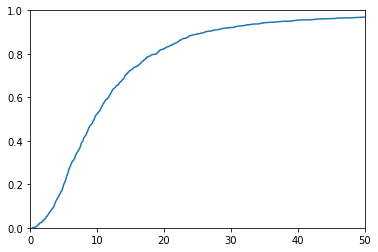

writing to file name:  mlp_layer_ap_ratio0.3.txt
CNN1 (None, 126, 32)
after conv1D (None, 16, 1)
after LSTM  (None, 16)


KeyboardInterrupt: 

In [7]:
def select_random_columns(ratio):
    select_columns = []
    for i in range(520):
        if np.random.random() < ratio:
            select_columns.append(i)
    return select_columns

if __name__ == '__main__':
    from sklearn import neighbors
    ratios = [0.3,0.7,0.5,0.3,0.1]
    for ratio in ratios:
        columns = select_random_columns(ratio)
        print(columns)
        path_train = "trainingData.csv"
        path_validation = "validationData.csv"
        train_df = pd.read_csv(path_train,header = 0)
        train_AP_strengths =train_df.loc[:,'WAP001':'WAP520']
        building_ids_str = train_df["BUILDINGID"].map(str) #convert all the building ids to strings
        building_floors_str = train_df["FLOOR"].map(str) #convert all the building floors to strings
        floor_enc = LabelEncoder()
        floor_enc.fit(building_floors_str)
        floor_id = floor_enc.transform(building_floors_str)
        floor_id = floor_id.reshape(-1,1)
        building_enc = LabelEncoder()
        building_enc.fit(building_ids_str)
        building_id = building_enc.transform(building_ids_str)
        train_building_id = building_id.reshape(-1,1)
        train_AP_features = np.array(train_AP_strengths.replace([100],[-150]))   
        train_AP_features = train_AP_features[:,columns]
        
        dimensions = train_AP_features.shape[1]
        train_id = np.argsort(train_AP_features)[:,dimensions-int(16*ratio):dimensions]
        train_rssi = np.sort(train_AP_features)[:,dimensions-int(16*ratio):dimensions]
        print(train_rssi.shape)
        #print(train_rssi[10])
        #print(train_id[10])
        #print(train_AP_features[train_id[10]])
        train_df_LL = train_df.loc[:,'LONGITUDE':'LATITUDE']
        train_labels = np.asarray(train_df_LL)
        train_y,ranges,bias =  normalization(train_labels)
        #print(bias,ranges)
        test_df = pd.read_csv(path_validation,header = 0)
        #print(test_df.head(2))
        test_AP_strengths =test_df.loc[:,'WAP001':'WAP520']
        #test_AP_features = np.array(test_AP_strengths.replace([100], [-100]))
        test_building_ids_str = test_df["BUILDINGID"].map(str) #convert all the building ids to strings
        test_building_floors_str = test_df["FLOOR"].map(str) #convert all the building floors to strings
        #print(id_label)
        test_floor_enc = LabelEncoder()
        test_floor_enc.fit(building_floors_str)
        test_floor_id = test_floor_enc.transform(test_building_floors_str)
        test_floor_id = test_floor_id.reshape(-1,1)
        #print("test floor id",(test_floor_id.shape))
        test_building_enc = LabelEncoder()
        test_building_enc.fit(test_building_ids_str)
        test_building_id = test_building_enc.transform(test_building_ids_str)
        test_building_id = test_building_id.reshape(-1,1)
        #print("test building id:",(test_building_id.shape))
        test_AP_features = np.array(test_AP_strengths.replace([100],[-150]))
        test_AP_features = test_AP_features[:,columns]
        test_id = np.argsort(test_AP_features)[:,dimensions-int(16*ratio):dimensions]
        test_rssi = np.sort(test_AP_features)[:,dimensions-int(16*ratio):dimensions]
        print(test_rssi.shape)
        test_rssi_floor = np.hstack((test_rssi,test_floor_id))
        #print(test_rssi_floor[0], test_rssi_floor.shape)
        test_df_LL = test_df.loc[:,'LONGITUDE':'LATITUDE']
        test_y = np.asarray(test_df_LL)

        
        
        
        input_data = [train_id, train_rssi, train_building_id]
        #LSTM
        
        
        model = mlp(input_data)
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'mlp_layer_ap_ratio' + str(ratio)+ '.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()
        
        
        
        model = cnn_lstm(input_data)
        #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'cnn_lstm_layer_ap_ratio' + str(i*0.1)+ '.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()

        model = lstm(input_data)
        #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'lstm_layer_ap_ratio' + str(i*0.1)+ '.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()

        
        # CNN
        model = cnn(input_data)
        #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
        model.fit(input_data,train_y,nb_epoch=100,batch_size=128,verbose = 1)
        test_pred_y = model.predict([test_id, test_rssi, test_building_id])
        test_pred_y = test_pred_y * ranges + bias 
        error_analysis(test_y, test_pred_y)
        fileName = 'cnn_layer_ap_ratio' + str(i*0.1)+ '.txt'
        print("writing to file name: ", fileName)
        file = open(fileName,'wb')
        pickle.dump(test_pred_y,file)
        file.close()

    